In [7]:
import cv2         
import numpy as np   
import matplotlib.pyplot as plt

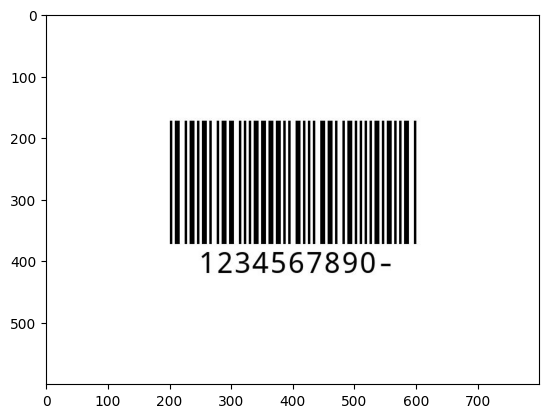

In [8]:
img = cv2.imread("Test Cases/01 - lol easy.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_gray)
plt.show()


In [9]:
qr_00_thresh_inv = cv2.bitwise_not(img_gray)
x, y, w, h = cv2.boundingRect(qr_00_thresh_inv)

qr_00_cropped = img[y:y+h-h//4, x:x+w]
plt.imshow(qr_00_cropped, cmap='gray')

plt.show()

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\shapedescr.cpp:1044: error: (-215:Assertion failed) img.depth() <= CV_8S && img.channels() == 1 in function 'cv::maskBoundingRect'
